In [1]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'
import deepxde as dde
dde.config.set_default_float('float64')
import numpy as np
import torch
import h5py
import matplotlib.pyplot as plt
import re  # Importar o módulo 're' para manipulação de expressões regulares

# Verificar o backend ativo
print(f"Backend ativo: {dde.config.backend_name}")

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64
Backend ativo: pytorch


In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Metaparameter, constants
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

U_REF = 0.005 # freeflow velocity in m/s, to normalize DNS data
L_REF = 1
MU  = 0.001 # in (Pa·s or Ns/m^2)
RHO = 998      # in kg/m**3
NU  = MU/RHO
P_REF = RHO * U_REF**2  # Reference Pressure (ρ * U_ref^2)

PERCENT = 0.05 #Percentage CFD data used for Supervised Learning

# Training parameter
NUM_DOMAIN = 1000
NUM_BOUNDARY = 1000
ACTIVATION = "tanh"
INITIALIZER = "Glorot uniform"
#LOSS_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1]

# Setup Neural Net dimensions
HIDDEN_LAYER = 6
NEURONS = 100
INPUT_DIM = 2    # x, y
OUTPUT_DIM = 6   # (u, v, p, u'u', u'v', v'v')
LAYER_SIZE = [INPUT_DIM] + [NEURONS] * HIDDEN_LAYER + [OUTPUT_DIM]

# filepaths
file_path='TJUNCTIONNODES.cgns'

In [ ]:
# Function to normalize data using reference values
def normalize_reference(data, reference_value):
    """
    Normalizes the data by dividing it by the reference value.
    
    Args:
        data (np.ndarray): Data to be normalized.
        reference_value (float): Reference value for normalization.
    
    Returns:
        np.ndarray: Normalized data.
    """
    return data / reference_value

# Function to denormalize data using reference values
def denormalize_reference(data, reference_value):
    """
    Denormalizes the data by multiplying it by the reference value.
    
    Args:
        data (np.ndarray): Normalized data.
        reference_value (float): Reference value for denormalization.
    
    Returns:
        np.ndarray: Denormalized data.
    """
    return data * reference_value

# Function to extract data from the CGNS file and apply normalization with reference values
def extract_and_normalize(file_path):
    with h5py.File(file_path, 'r') as f:
        # Extract coordinates
        grid_coords = f['Base/Zone/GridCoordinates']
        x_coords = grid_coords['CoordinateX/ data'][:]
        y_coords = grid_coords['CoordinateY/ data'][:]

        # Extract global solutions (velocities and pressure)
        solution_data = f['Base/Zone/FlowSolution.N:1']
        velocity_x = solution_data['VelocityX/ data'][:]
        velocity_y = solution_data['VelocityY/ data'][:]
        pressure = solution_data['Pressure/ data'][:]

        # Normalize using the reference values
        velocity_x_norm = normalize_reference(velocity_x, U_REF)
        velocity_y_norm = normalize_reference(velocity_y, U_REF)
        pressure_norm = normalize_reference(pressure, P_REF)

        # Store normalization parameters
        normalization_params = {
            "U_REF": U_REF,
            "P_REF": P_REF,
            "L_REF": L_REF
        }

        # Process specific zones
        zones_of_interest = ['interior-surface_body', 'inlet', 'outlet1', 'outlet2', 'wall-surface_body'] #Just "outlet" for sudden expansion
        zone_data = {}

        for zone in zones_of_interest:
            try:
                # Get element connectivity of the zone
                element_connectivity = f[f'Base/Zone/{zone}/ElementConnectivity/ data'][:]
                unique_node_ids = np.unique(element_connectivity).astype(int)

                valid_indices = unique_node_ids - 1
                valid_indices = valid_indices[(valid_indices >= 0) & (valid_indices < len(x_coords))]

                # Organize normalized data
                zone_data[zone] = {
                    'x_coords': normalize_reference(x_coords[valid_indices], L_REF),
                    'y_coords': normalize_reference(y_coords[valid_indices], L_REF),
                    'velocity_x': velocity_x_norm[valid_indices],
                    'velocity_y': velocity_y_norm[valid_indices],
                    'pressure': pressure_norm[valid_indices]
                }
            except KeyError as e:
                print(f"Error accessing zone {zone}: {e}")

        return zone_data, normalization_params


In [4]:
def load_training_data_from_zones(selected_zone=None, num_points_per_zone=None):
    """
    Unified function to load data from a specific zone or from all available zones.
    If 'num_points_per_zone' is None, all available points in the zone will be loaded.
    If 'num_points_per_zone' is specified, random sampling will be applied.

    Args:
        selected_zone (str): Name of the zone to be loaded.
                             If None, all available zones will be loaded.
        num_points_per_zone (int): Number of points to be sampled.

    Returns:
        x_train, y_train, u_train, v_train, p_train, normalization_params
    """
    zone_data, normalization_params = extract_and_normalize(file_path)

    selected_data = []

    if selected_zone:
        if selected_zone in zone_data:
            data = zone_data[selected_zone]
            total_points = len(data['x_coords'])
            
            # Select all points if num_points_per_zone is None
            if num_points_per_zone is None:
                indices = np.arange(total_points)  # All indices
            else:
                num_points = min(num_points_per_zone, total_points)
                indices = np.random.choice(total_points, num_points, replace=False)
            
            x = data['x_coords'][indices][:, None]
            y = data['y_coords'][indices][:, None]
            u = data['velocity_x'][indices][:, None]
            v = data['velocity_y'][indices][:, None]
            p = data['pressure'][indices][:, None]
            
            return [x, y, u, v, p, normalization_params]
        else:
            print(f"Zone '{selected_zone}' not found in the available data.")
            return None
    else:
        for zone, data in zone_data.items():
            total_points = len(data['x_coords'])

            if num_points_per_zone is None:
                indices = np.arange(total_points)  # All indices
            else:
                num_points = min(num_points_per_zone, total_points)
                indices = np.random.choice(total_points, num_points, replace=False)

            x = data['x_coords'][indices][:, None]
            y = data['y_coords'][indices][:, None]
            u = data['velocity_x'][indices][:, None]
            v = data['velocity_y'][indices][:, None]
            p = data['pressure'][indices][:, None]

            zone_selected_data = np.concatenate([x, y, u, v, p], axis=1)
            selected_data.append(zone_selected_data)

        selected_data = np.concatenate(selected_data, axis=0)

    x_train = selected_data[:, 0:1]
    y_train = selected_data[:, 1:2]
    u_train = selected_data[:, 2:3]
    v_train = selected_data[:, 3:4]
    p_train = selected_data[:, 4:5]

    return [x_train, y_train, u_train, v_train, p_train, normalization_params]


In [5]:
import numpy as np

def load_training_data_with_decoupled_supervision(selected_zone=None, percent=PERCENT, seed=1):
    """
    Function to load data from a specific zone for each variable u, v, and p with independent point selection,
    while ensuring consistency when reducing the number of points.
    
    Args:
        selected_zone (str): Name of the zone to be loaded.
        percent (float): Percentage of points to be sampled for variables u, v, and p (value between 0 and 1).
        seed (int): Seed to ensure consistency in the selected points.

    Returns:
        List containing [xy_u, u_values, xy_v, v_values, xy_p, p_values, normalization_params]
    """
    # Load and normalize data
    zone_data, normalization_params = extract_and_normalize(file_path)

    # Set the seed for reproducibility
    np.random.seed(seed)

    if selected_zone:
        if selected_zone in zone_data:
            data = zone_data[selected_zone]
            total_points = len(data['x_coords'])

            # Generate consistent indices for each variable with different shuffles
            base_indices_u = np.arange(total_points)
            np.random.shuffle(base_indices_u)
            base_indices_v = np.arange(total_points)
            np.random.shuffle(base_indices_v)
            base_indices_p = np.arange(total_points)
            np.random.shuffle(base_indices_p)

            # Calculate the number of points and select the subset consistently
            num_points = int(percent * total_points)
            num_points = max(1, num_points)  # Ensure at least 1 point

            selected_indices_u = base_indices_u[:num_points]
            selected_indices_v = base_indices_v[:num_points]
            selected_indices_p = base_indices_p[:num_points]

            # Coordinates and values for u, v, and p
            x_u = data['x_coords'][selected_indices_u][:, None]
            y_u = data['y_coords'][selected_indices_u][:, None]
            u_values = data['velocity_x'][selected_indices_u][:, None]
            xy_u = np.hstack((x_u, y_u))
            
            x_v = data['x_coords'][selected_indices_v][:, None]
            y_v = data['y_coords'][selected_indices_v][:, None]
            v_values = data['velocity_y'][selected_indices_v][:, None]
            xy_v = np.hstack((x_v, y_v))

            x_p = data['x_coords'][selected_indices_p][:, None]
            y_p = data['y_coords'][selected_indices_p][:, None]
            p_values = data['pressure'][selected_indices_p][:, None]
            xy_p = np.hstack((x_p, y_p))
            
            return [xy_u, u_values, xy_v, v_values, xy_p, p_values, normalization_params]
        else:
            print(f"Zone '{selected_zone}' not found in the available data.")
            return [None] * 7  # Return list of Nones to maintain structure
    else:
        # Initialize lists to store data from all zones
        xy_u_list = []
        u_values_list = []
        xy_v_list = []
        v_values_list = []
        xy_p_list = []
        p_values_list = []

        for zone, data in zone_data.items():
            total_points = len(data['x_coords'])

            # Generate consistent indices for each variable
            base_indices_u = np.arange(total_points)
            np.random.shuffle(base_indices_u)
            base_indices_v = np.arange(total_points)
            np.random.shuffle(base_indices_v)
            base_indices_p = np.arange(total_points)
            np.random.shuffle(base_indices_p)

            num_points = int(percent * total_points)
            num_points = max(1, num_points)

            selected_indices_u = base_indices_u[:num_points]
            selected_indices_v = base_indices_v[:num_points]
            selected_indices_p = base_indices_p[:num_points]

            # Coordinates and values for u, v, and p
            x_u = data['x_coords'][selected_indices_u][:, None]
            y_u = data['y_coords'][selected_indices_u][:, None]
            u_values = data['velocity_x'][selected_indices_u][:, None]
            xy_u = np.hstack((x_u, y_u))
            xy_u_list.append(xy_u)
            u_values_list.append(u_values)
            
            x_v = data['x_coords'][selected_indices_v][:, None]
            y_v = data['y_coords'][selected_indices_v][:, None]
            v_values = data['velocity_y'][selected_indices_v][:, None]
            xy_v = np.hstack((x_v, y_v))
            xy_v_list.append(xy_v)
            v_values_list.append(v_values)

            x_p = data['x_coords'][selected_indices_p][:, None]
            y_p = data['y_coords'][selected_indices_p][:, None]
            p_values = data['pressure'][selected_indices_p][:, None]
            xy_p = np.hstack((x_p, y_p))
            xy_p_list.append(xy_p)
            p_values_list.append(p_values)
        
        # Concatenate data from all zones
        xy_u = np.vstack(xy_u_list)
        u_values = np.vstack(u_values_list)
        
        xy_v = np.vstack(xy_v_list)
        v_values = np.vstack(v_values_list)
        
        xy_p = np.vstack(xy_p_list)
        p_values = np.vstack(p_values_list)

    return [xy_u, u_values, xy_v, v_values, xy_p, p_values, normalization_params]


Number of available points per zone:

Zone: interior-surface_body - 4357 points available
Zone: inlet - 28 points available
Zone: outlet1 - 20 points available
Zone: outlet2 - 19 points available
Zone: wall-surface_body - 379 points available


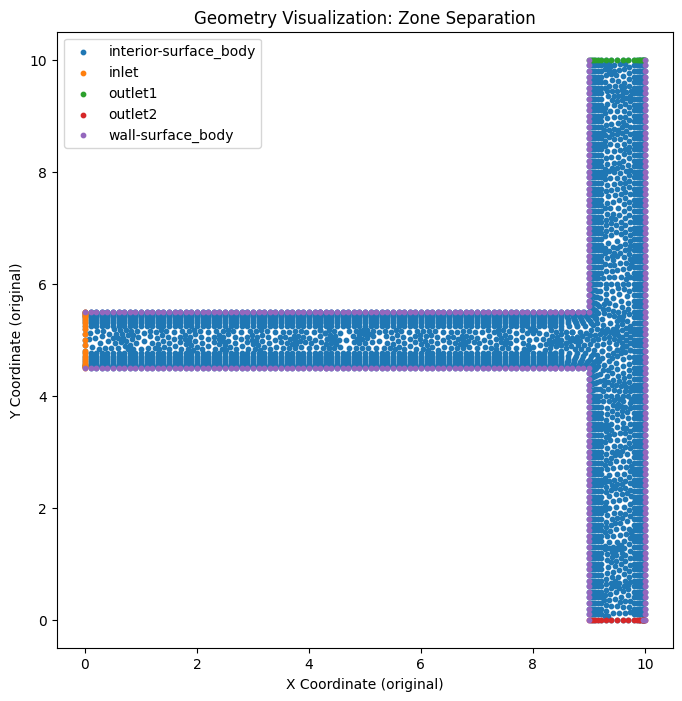

In [6]:
def visualize_geometry(zone_data):
    plt.figure(figsize=(8, 8))

    # Plot the points of each zone using different colors
    for zone, data in zone_data.items():
        x_coords = data['x_coords']  # X coordinates (not normalized)
        y_coords = data['y_coords']  # Y coordinates (not normalized)
        plt.scatter(x_coords, y_coords, label=f'{zone}', s=10)

    plt.title('Geometry Visualization: Zone Separation')
    plt.xlabel('X Coordinate (original)')
    plt.ylabel('Y Coordinate (original)')
    plt.legend()

    # Adjust the aspect ratio so that X and Y have equal scale
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(False)
    plt.show()

# Function to count the number of available points in each zone
def check_number_of_points(zone_data):
    print("Number of available points per zone:\n")
    for zone, data in zone_data.items():
        num_points = len(data['x_coords'])
        print(f"Zone: {zone} - {num_points} points available")

# Call the function to extract the data and normalize only velocity and pressure
zone_data, normalization_params = extract_and_normalize(file_path)  # Also returns the normalization parameters

# Check number of points per zone
check_number_of_points(zone_data)

# Visualize geometry (coordinates not normalized)
visualize_geometry(zone_data)


In [7]:
zone_data, normalization_params = extract_and_normalize(file_path)

# Load interior data using decoupled supervision
[xy_u_interior, u_values_interior, xy_v_interior, v_values_interior, xy_p_interior, p_values_interior, normalization_params_interior] = load_training_data_with_decoupled_supervision(
    selected_zone="interior-surface_body", 
    percent=PERCENT
)

# Coordinates and supervised values from the interior
interior_u_coords, interior_u_values = xy_u_interior, u_values_interior
interior_v_coords, interior_v_values = xy_v_interior, v_values_interior
interior_p_coords, interior_p_values = xy_p_interior, p_values_interior

# Extract boundary data
[x_train_inlet, y_train_inlet, u_train_inlet, v_train_inlet, p_train_inlet, normalization_params_inlet] = load_training_data_from_zones(selected_zone='inlet', num_points_per_zone=None)
[x_train_outlet1, y_train_outlet1, u_train_outlet1, v_train_outlet1, p_train_outlet1, normalization_params_outlet1] = load_training_data_from_zones(selected_zone='outlet1', num_points_per_zone=None)
[x_train_outlet2, y_train_outlet2, u_train_outlet2, v_train_outlet2, p_train_outlet2, normalization_params_outlet2] = load_training_data_from_zones(selected_zone='outlet2', num_points_per_zone=None)
[x_train_walls, y_train_walls, u_train_walls, v_train_walls, p_train_walls, normalization_params_walls] = load_training_data_from_zones(selected_zone='wall-surface_body', num_points_per_zone=None)

# Combine data from boundary zones
boundary_coordinates = np.vstack((
    np.column_stack((x_train_inlet, y_train_inlet)),
    np.column_stack((x_train_outlet1, y_train_outlet1)),
    np.column_stack((x_train_outlet2, y_train_outlet2)),
    np.column_stack((x_train_walls, y_train_walls))
))

boundary_u_values = np.concatenate((u_train_inlet, u_train_outlet1, u_train_outlet2, u_train_walls))
boundary_v_values = np.concatenate((v_train_inlet, v_train_outlet1, v_train_outlet2, v_train_walls))
boundary_p_values = np.concatenate((p_train_inlet, p_train_outlet1, p_train_outlet2, p_train_walls))

# List of boundary conditions separated by region
boundary_conditions = [
    # Inlet
    dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), u_train_inlet, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), v_train_inlet, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_inlet, y_train_inlet)), p_train_inlet, component=2),

    # Outlet 1
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), u_train_outlet1, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), v_train_outlet1, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_outlet1, y_train_outlet1)), p_train_outlet1, component=2),

    # Outlet 2
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), u_train_outlet2, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), v_train_outlet2, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_outlet2, y_train_outlet2)), p_train_outlet2, component=2),

    # Walls
    dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), u_train_walls, component=0),
    dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), v_train_walls, component=1),
    #dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), p_train_walls, component=2),
]

# Combine all supervised coordinates from the interior and boundaries
all_xy = np.vstack((interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates))

# Define the geometry using the domain coordinates
#geom = dde.geometry.PointCloud(points=np.vstack((interior_u_coords, interior_v_coords, interior_p_coords)),boundary_points=boundary_coordinates)
geom = dde.geometry.geometry_2d.Polygon([[0, 4.5], [0, 5.5], [9, 5.5], [9, 10], [10, 10],[10, 0],[9, 0],[9, 4.5]])

# Define observation conditions for variables u, v and p
observe_u = dde.icbc.PointSetBC(interior_u_coords, interior_u_values, component=0)
observe_v = dde.icbc.PointSetBC(interior_v_coords, interior_v_values, component=1)
observe_p = dde.icbc.PointSetBC(interior_p_coords, interior_p_values, component=2)

#wall_u = dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), [0.0], component=0)
#wall_v = dde.icbc.PointSetBC(np.column_stack((x_train_walls, y_train_walls)), [0.0], component=1)

#walls = [wall_u, wall_v]


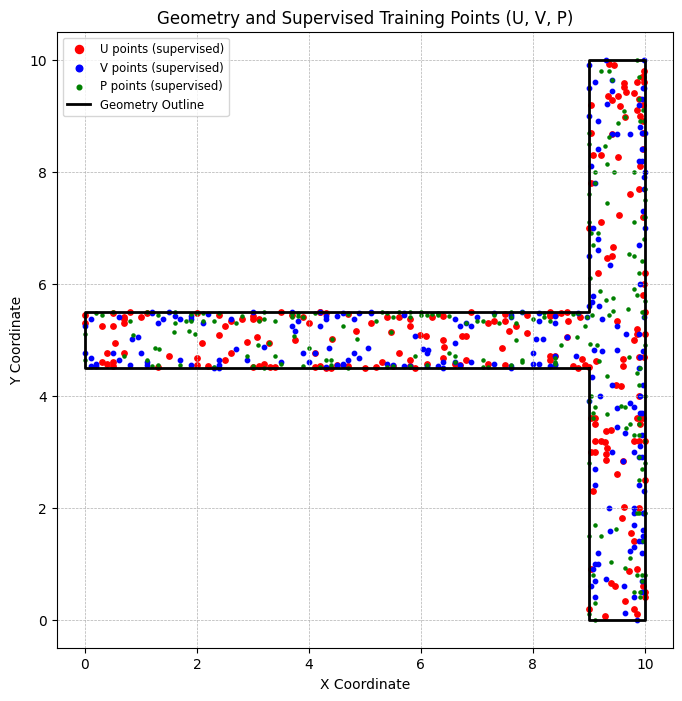

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training_points(interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates, geom):
    """
    Visualize the geometry and the training points for U, V, and P within the domain.
    The geometry is outlined with a solid black line using the vertices from the Polygon.
    
    Args:
        interior_u_coords (ndarray): Coordinates of supervised U points.
        interior_v_coords (ndarray): Coordinates of supervised V points.
        interior_p_coords (ndarray): Coordinates of supervised P points.
        boundary_coordinates (ndarray): Coordinates of boundary points (optional, may not be used in this version).
        geom (Polygon): The geometry of the domain as a DeepXDE polygon.
    """
    plt.figure(figsize=(10, 8))

    # Plot U, V, and P training points inside the domain with distinct colors
    plt.scatter(interior_u_coords[:, 0], interior_u_coords[:, 1], color='red', s=15, label='U points (supervised)')
    plt.scatter(interior_v_coords[:, 0], interior_v_coords[:, 1], color='blue', s=10, label='V points (supervised)')
    plt.scatter(interior_p_coords[:, 0], interior_p_coords[:, 1], color='green', s=5, label='P points (supervised)')

    # Extract the vertices of the polygon to draw the geometry outline
    polygon_vertices = np.array(geom.vertices)  # Extract vertices from the Polygon
    polygon_vertices = np.vstack((polygon_vertices, polygon_vertices[0]))  # Close the loop of the polygon
    plt.plot(polygon_vertices[:, 0], polygon_vertices[:, 1], color='black', linewidth=2, label='Geometry Outline')

    plt.title('Geometry and Supervised Training Points (U, V, P)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', fontsize='small', markerscale=1.5)
    plt.gca().set_aspect('equal', adjustable='box')  # Maintain equal aspect ratio for x and y
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()


# Example of how to call the function
visualize_training_points(interior_u_coords, interior_v_coords, interior_p_coords, boundary_coordinates, geom)


Compiling model...
'compile' took 1.116012 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
0         [4.66e-03, 1.10e-02, 1.12e-03, 8.86e-01, 3.49e-02, 2.54e-01, 4.13e-01, 4.86e-01, 7.65e-02, 3.23e-01, 5.48e-02, 1.16e+00, 1.78e-01, 2.15e-02]    [4.66e-03, 1.10e-02, 1.12e-03, 8.86e-01, 3.49e-02, 2.54e-01, 4.13e-01, 4.86e-01, 7.65e-02, 3.23e-01, 5.48e-02, 1.16e+00, 1.78e-01, 2.15e-02]    []  
1000      [7.41e-03, 4.98e-05, 1.12e-04, 6.71e-02, 1.80e-03, 4.29e-04, 4.28e-02, 1.67e-04, 4.27e-02, 1.06e-01, 4.54e-02, 1.46e-01, 6.70e-02, 6.66e-03]    [7.41e-03, 4.98e-05, 1.12e-04, 6.71e-02, 1.80e-03, 4.29e-04, 4.28e-02, 1.67e-04, 4.27e-02, 1.06e-01, 4.54e-02, 1.46e-01, 6.70e-02, 6.66e-03]    []  
2000      [6.42e-03

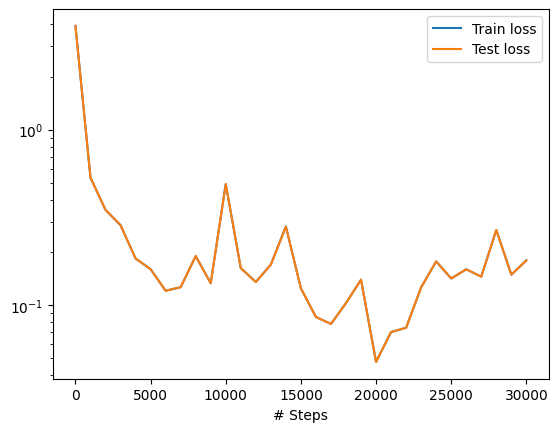

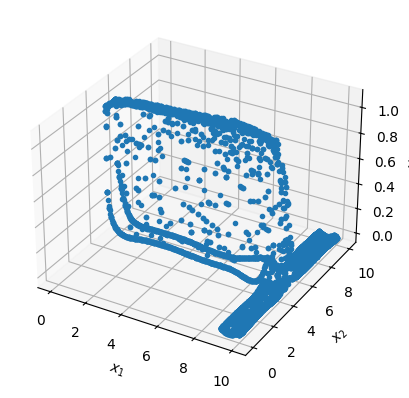

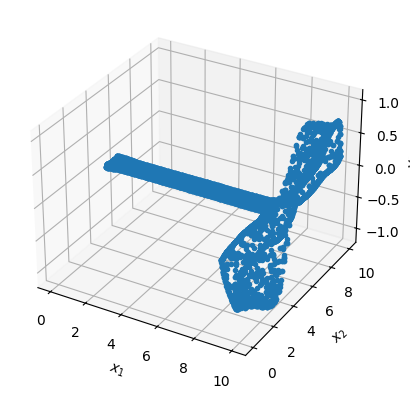

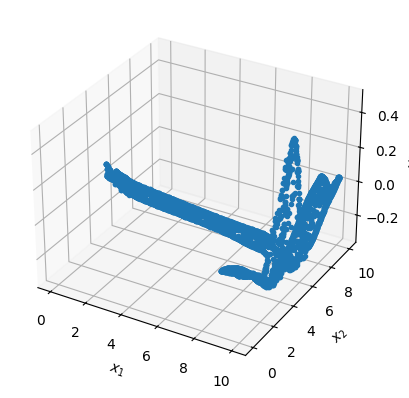

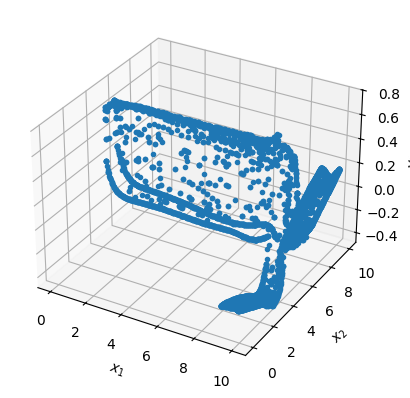

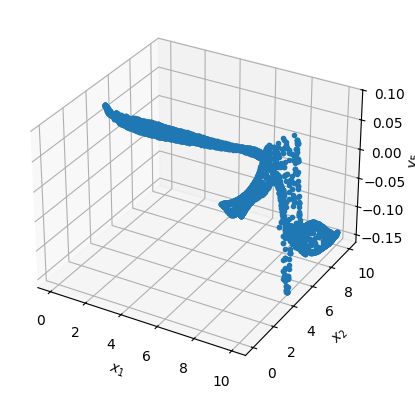

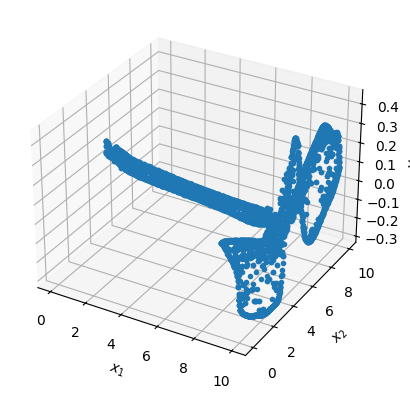

Compiling model...
'compile' took 0.000519 s

Training model...

Step      Train loss                                                                                                                                      Test loss                                                                                                                                       Test metric
30000     [6.74e-03, 7.09e-03, 9.56e-04, 5.15e-02, 1.60e-03, 1.80e-04, 1.25e-02, 4.17e-05, 1.71e-02, 2.29e-02, 1.31e-02, 3.37e-02, 1.24e-02, 3.50e-04]    [6.74e-03, 7.09e-03, 9.56e-04, 5.15e-02, 1.60e-03, 1.80e-04, 1.25e-02, 4.17e-05, 1.71e-02, 2.29e-02, 1.31e-02, 3.37e-02, 1.24e-02, 3.50e-04]    []  
31000     [9.24e-04, 7.38e-04, 3.93e-04, 2.36e-03, 1.57e-05, 6.27e-06, 1.21e-04, 7.86e-06, 1.42e-04, 2.86e-04, 3.70e-04, 6.57e-04, 9.91e-04, 1.90e-04]    [9.24e-04, 7.38e-04, 3.93e-04, 2.36e-03, 1.57e-05, 6.27e-06, 1.21e-04, 7.86e-06, 1.42e-04, 2.86e-04, 3.70e-04, 6.57e-04, 9.91e-04, 1.90e-04]    []  
32000     [5.72e-04

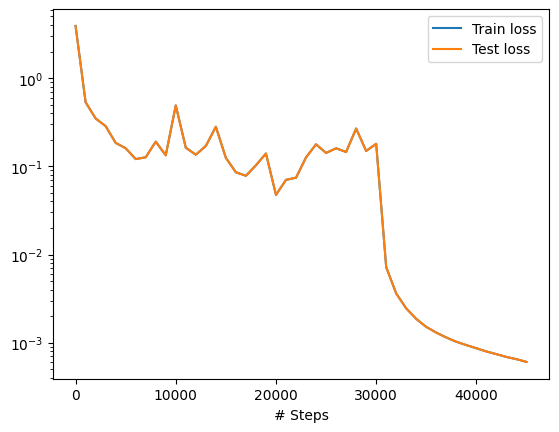

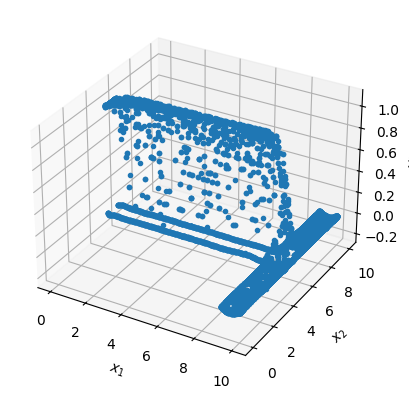

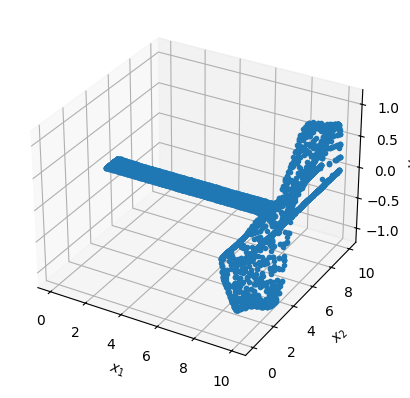

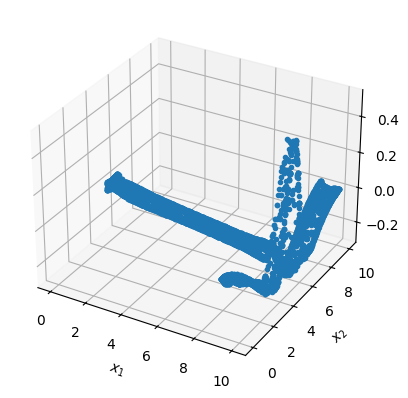

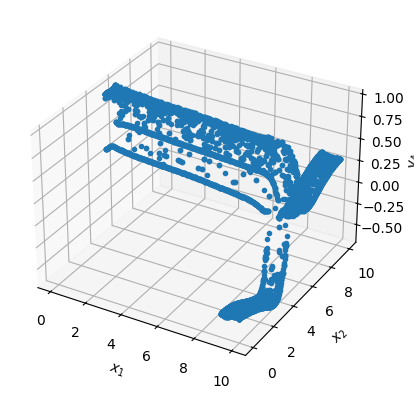

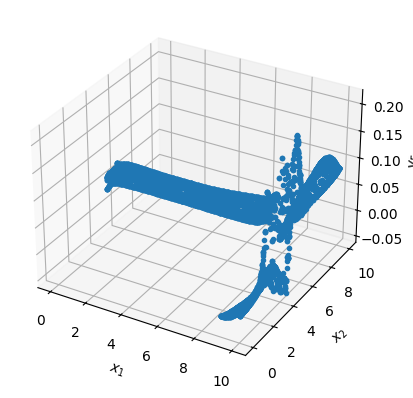

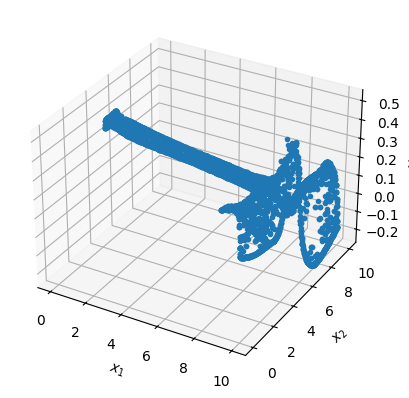

'8.0.4.ckpt-45000.pt'

In [9]:
# Part 2 - PINN Model (RANS with Reynolds Stress Tensor)

def RANS_Equations_Dimensionless(x, y):
    Re = (RHO * U_REF * L_REF) / MU  # Reynolds number

    # Dimensionless variables
    u = y[:, 0:1]  # Dimensionless velocity in the x-direction
    v = y[:, 1:2]  # Dimensionless velocity in the y-direction
    p = y[:, 2:3]  # Dimensionless pressure
    uu_reynolds = y[:, 3:4]  # Dimensionless Reynolds stress: u'u'
    uv_reynolds = y[:, 4:5]  # Dimensionless Reynolds stress: u'v'
    vv_reynolds = y[:, 5:6]  # Dimensionless Reynolds stress: v'v'

    # Dimensionless derivatives
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    dp_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=2, j=1)
    duu_dx = dde.grad.jacobian(y, x, i=3, j=0)
    duv_dy = dde.grad.jacobian(y, x, i=4, j=1)
    duv_dx = dde.grad.jacobian(y, x, i=4, j=0)
    dvv_dy = dde.grad.jacobian(y, x, i=5, j=1)
    du_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)
    dv_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)

    # Dimensionless RANS equations
    continuity = du_dx + dv_dy
    x_momentum = (u * du_dx + v * du_dy + dp_dx - (1 / Re) * (du_xx + du_yy) - duu_dx - duv_dy)
    y_momentum = (u * dv_dx + v * dv_dy + dp_dy - (1 / Re) * (dv_xx + dv_yy) - duv_dx - dvv_dy)

    return [continuity, x_momentum, y_momentum]

# Define the data for the PINN model
data = dde.data.PDE(
    geom,
    RANS_Equations_Dimensionless,
    [*boundary_conditions, observe_u, observe_v, observe_p],  # Observers (u, v, p inside + boundary)
    num_domain=NUM_DOMAIN,  # Collocation points in the interior
    num_boundary=NUM_BOUNDARY,  # Boundary points
    #train_distribution="LHS",
    anchors=all_xy  # All supervised points combined
)

# Configure the neural network (PINN)
layer_size = [INPUT_DIM] + [NEURONS] * HIDDEN_LAYER + [OUTPUT_DIM]  # 2 inputs (x, y) and 6 outputs (u, v, p, u'u', u'v', v'v')
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(LAYER_SIZE, ACTIVATION, INITIALIZER)

# Create the PINN model
model = dde.Model(data, net)

# Configure early stopping
early_stopping = dde.callbacks.EarlyStopping(min_delta=1e-6, patience=10000)

# Compile the model and train using Adam optimizer with early stopping
model.compile("adam", lr=1e-3)
loss_history, train_state = model.train(iterations=50000, callbacks=[early_stopping], display_every=1000, disregard_previous_best=True)
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

# L-BFGS optimization
dde.optimizers.config.set_LBFGS_options()
model.compile("L-BFGS")
checker = dde.callbacks.ModelCheckpoint("model.ckpt", save_better_only=True, period=1000)
loss_history, train_state = model.train(callbacks=[checker])
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

# Save trained model
model.save("8.0.4.ckpt")


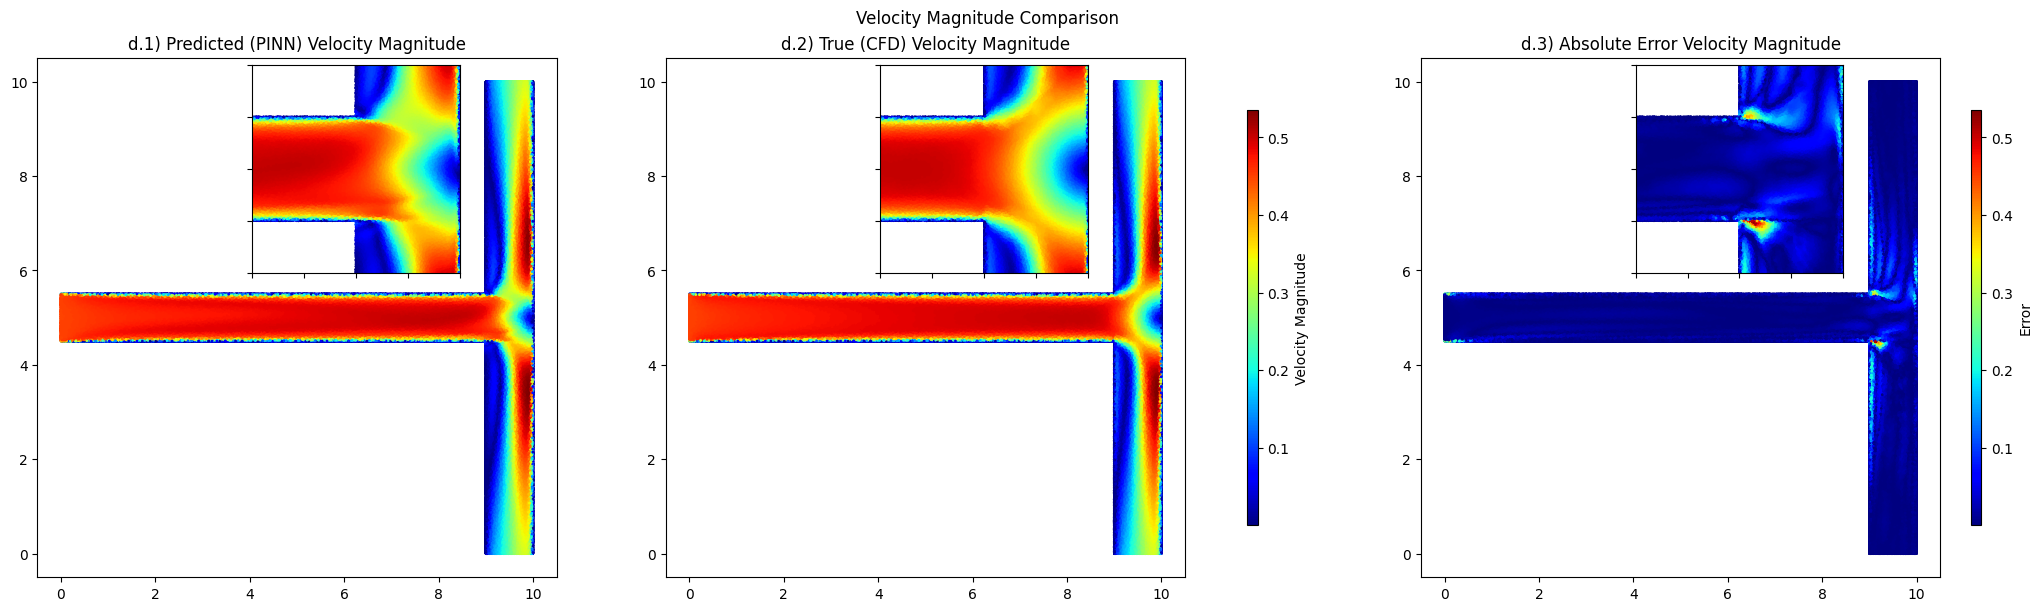

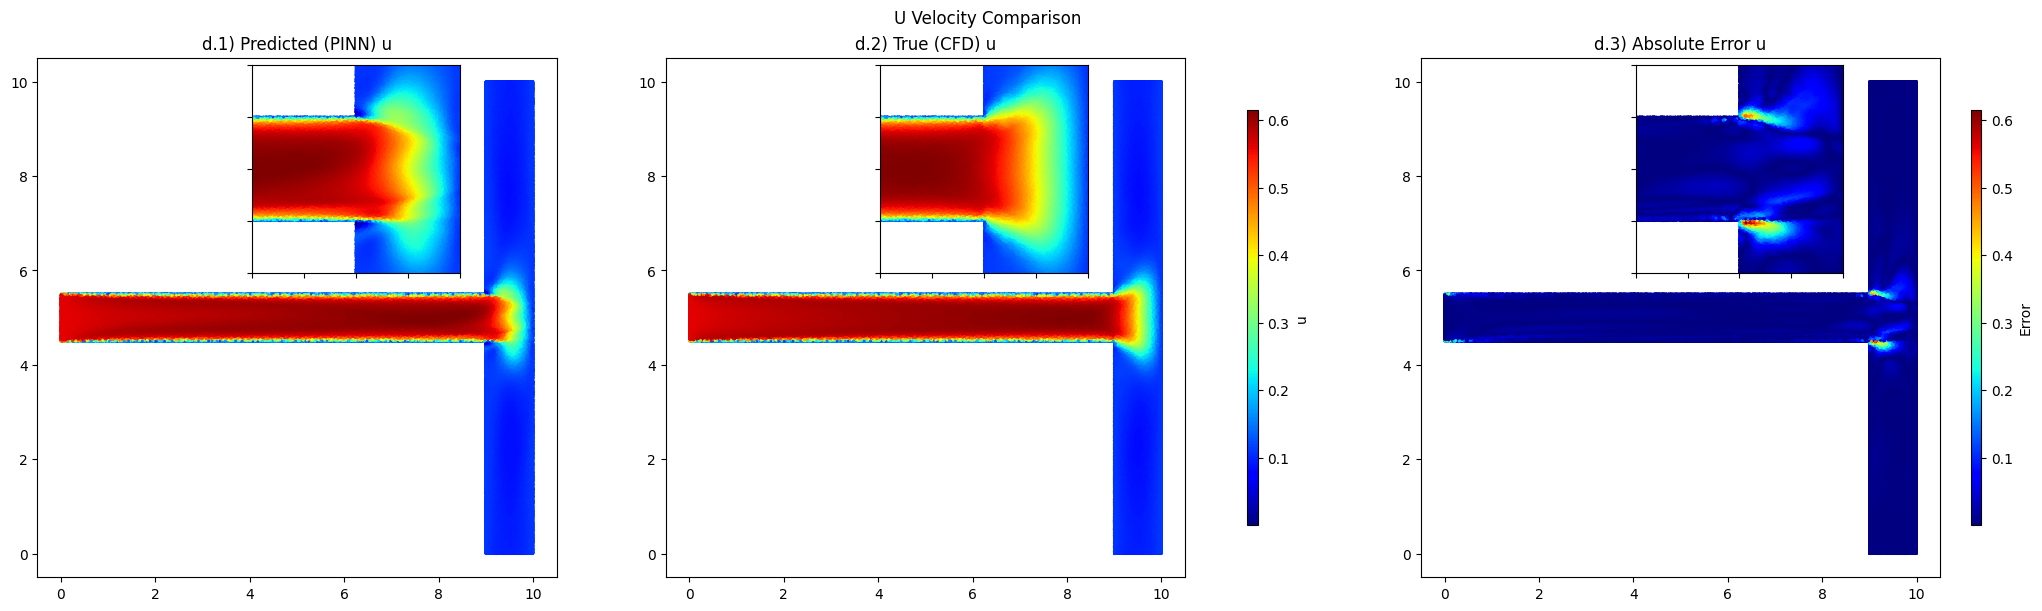

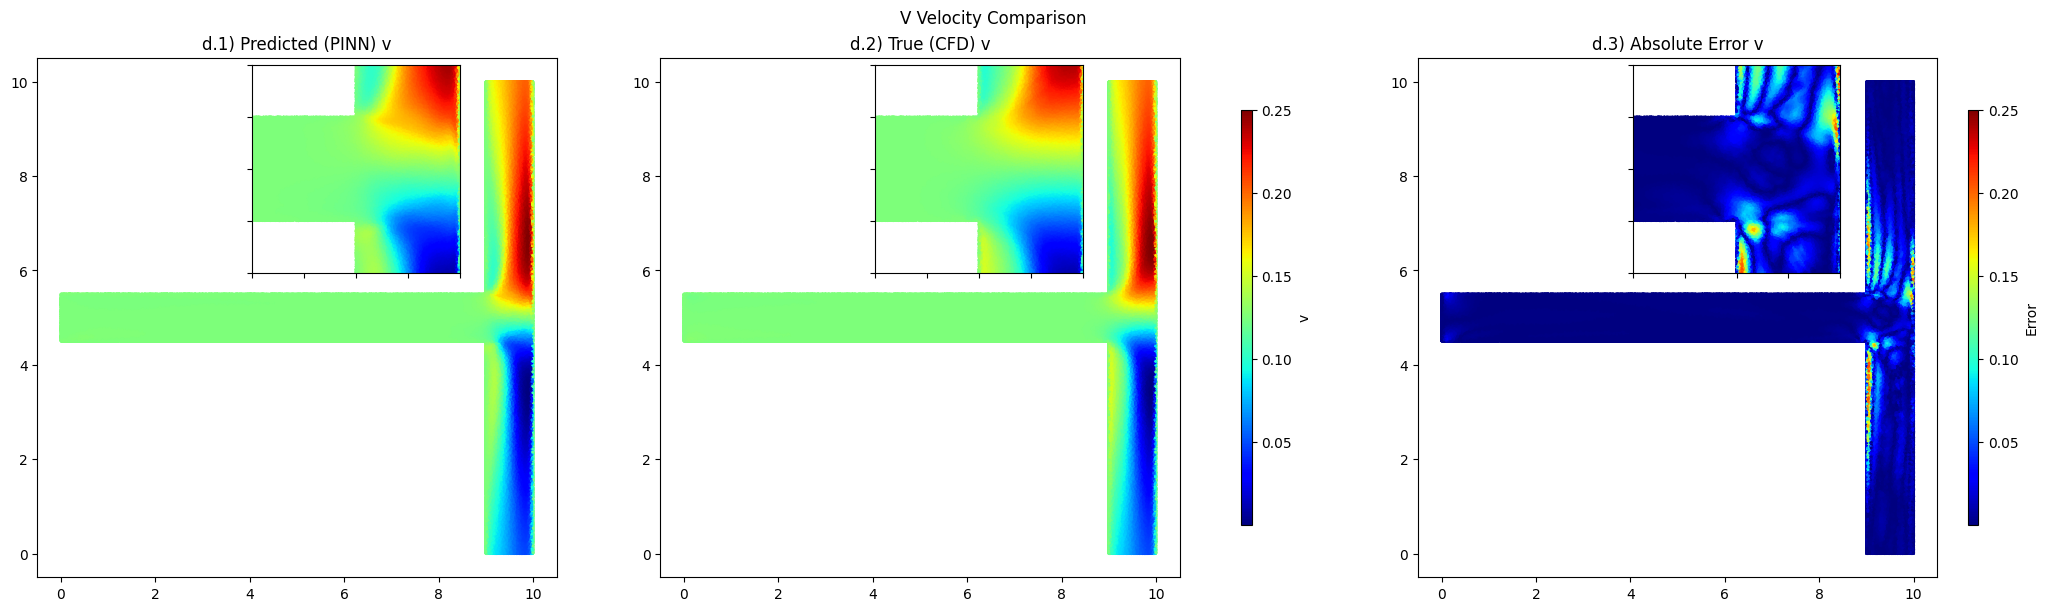

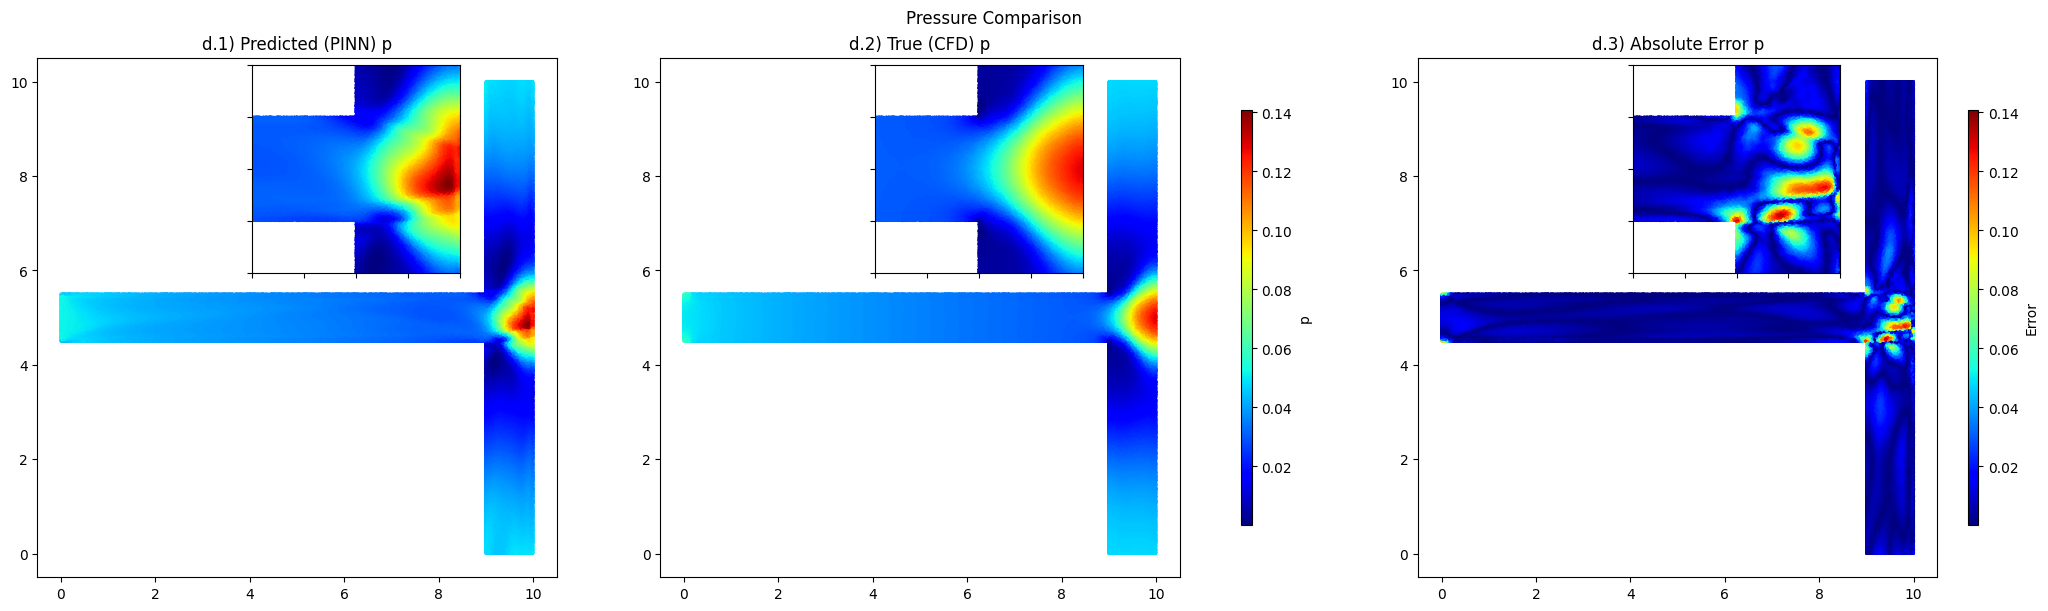

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata

# Load interior data (all available points)
[x_train_interior, y_train_interior, u_train_interior, v_train_interior, p_train_interior, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="interior-surface_body")

# Load inlet boundary data
[x_train_inlet, y_train_inlet, u_train_inlet, v_train_inlet, p_train_inlet, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="inlet")

# Load outlet 1 boundary data
[x_train_outlet1, y_train_outlet1, u_train_outlet1, v_train_outlet1, p_train_outlet1, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="outlet1")

# Load outlet 2 boundary data
[x_train_outlet2, y_train_outlet2, u_train_outlet2, v_train_outlet2, p_train_outlet2, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="outlet2")

# Load wall boundary data
[x_train_walls, y_train_walls, u_train_walls, v_train_walls, p_train_walls, _] = load_training_data_from_zones(
    num_points_per_zone=None,  # Extract all available points
    selected_zone="wall-surface_body")


# --- Generation of a new high-resolution mesh within the geometry ---
num_points = 900000  # Number of high-resolution points
dense_xy = geom.random_points(num_points)  # Generate points inside the geometry

# --- PINN predictions over the dense domain ---
predictions_dense = model.predict(dense_xy)

# --- Extract predictions for u, v, and p ---
u_pred_dense = predictions_dense[:, 0]
v_pred_dense = predictions_dense[:, 1]
p_pred_dense = predictions_dense[:, 2]

# --- Denormalize the predictions using reference values ---
u_pred_denorm = u_pred_dense
v_pred_denorm = v_pred_dense
p_pred_denorm = p_pred_dense

# --- Compute the velocity magnitude ---
velocity_magnitude_pred = np.sqrt(u_pred_denorm**2 + v_pred_denorm**2)

# --- Retrieve the CFD reference values for u, v, and p ---
all_x_coords = np.concatenate([x_train_interior, x_train_inlet, x_train_outlet1, x_train_outlet2, x_train_walls], axis=0)
all_y_coords = np.concatenate([y_train_interior, y_train_inlet, y_train_outlet1, y_train_outlet2, y_train_walls], axis=0)
all_u = np.concatenate([u_train_interior, u_train_inlet, u_train_outlet1, u_train_outlet2, u_train_walls], axis=0)
all_v = np.concatenate([v_train_interior, v_train_inlet, v_train_outlet1, v_train_outlet2, v_train_walls], axis=0)
all_p = np.concatenate([p_train_interior, p_train_inlet, p_train_outlet1, p_train_outlet2, p_train_walls], axis=0)

# --- Denormalize CFD data ---
u_true_denorm = all_u.flatten()
v_true_denorm = all_v.flatten()
p_true_denorm = all_p.flatten()

# --- Interpolate CFD data onto the dense mesh ---
points_cfd = np.vstack((all_x_coords.flatten(), all_y_coords.flatten())).T  # Coordinates (x, y) from CFD data
u_true_dense = griddata(points_cfd, u_true_denorm, dense_xy, method='linear')
v_true_dense = griddata(points_cfd, v_true_denorm, dense_xy, method='linear')
p_true_dense = griddata(points_cfd, p_true_denorm, dense_xy, method='linear')

velocity_magnitude_true = np.sqrt(u_true_dense**2 + v_true_dense**2)

# --- Compute absolute errors between PINN prediction and CFD ---
error_velocity = np.abs(velocity_magnitude_pred - velocity_magnitude_true)
error_u = np.abs(u_pred_denorm - u_true_dense)
error_v = np.abs(v_pred_denorm - v_true_dense)
error_p = np.abs(p_pred_denorm - p_true_dense)

def prepare_data(x, y, pred, true, error):
    """
    Prepares the data for plotting, including optional interpolation onto a regular mesh.
    Returns the processed data to ensure that the original arrays remain unmodified.
    """
    return x, y, pred, true, error

def plot_comparison_with_internal_zoom(x, y, pred, true, error, title, component_name, vmin, vmax, vmin_err, vmax_err, index_label, zoom_region):
    """
    Plots a comparison of predicted, true, and error values for a given variable with internal zoom for detail.
    
    Args:
        x, y: Coordinates of the data points.
        pred: Predicted values from the model.
        true: Reference CFD values.
        error: Absolute error between predicted and true.
        title: Main title of the plot.
        component_name: Variable name (e.g., u, v, p).
        vmin/vmax: Limits for prediction and true plots.
        vmin_err/vmax_err: Limits for error plot.
        index_label: Label prefix (e.g., "d").
        zoom_region: Dictionary with x_min, x_max, y_min, y_max to define the zoom window.
    """
    fig, ax = plt.subplots(1, 3, figsize=(21, 6), constrained_layout=True)

    x, y, pred, true, error = prepare_data(x, y, pred, true, error)

    cmap = "jet"
    norm_pred_true = Normalize(vmin=vmin, vmax=vmax)
    norm_error = Normalize(vmin=vmin_err, vmax=vmax_err)

    titles = ['Predicted (PINN)', 'True (CFD)', 'Absolute Error']
    data = [pred, true, error]
    insets = []

    for i in range(3):
        sc = ax[i].scatter(x, y, c=data[i], cmap=cmap, s=1, norm=norm_pred_true if i < 2 else norm_error)
        ax[i].set_title(f"{index_label}.{i+1}) {titles[i]} {component_name}")
        ax[i].set_aspect("equal")
        
        # Create zoom inset
        insets.append(inset_axes(ax[i], width="100%", height="100%", loc='upper left',
                                 bbox_to_anchor=(0.4, 0.6, 0.4, 0.4), bbox_transform=ax[i].transAxes))
        insets[i].scatter(x, y, c=data[i], cmap=cmap, s=1, norm=norm_pred_true if i < 2 else norm_error)
        insets[i].set_xlim(zoom_region['x_min'], zoom_region['x_max'])
        insets[i].set_ylim(zoom_region['y_min'], zoom_region['y_max'])
        insets[i].set_xticklabels([])
        insets[i].set_yticklabels([])

    cbar = fig.colorbar(sc, ax=ax[:2], location="right", aspect=40, shrink=0.8, pad=0.05)
    cbar.set_label(component_name)
    cbar_error = fig.colorbar(sc, ax=ax[2], location="right", aspect=40, shrink=0.8, pad=0.05)
    cbar_error.set_label("Error")

    plt.suptitle(title)
    plt.show()

# Example calls with input data
zoom_region = {'x_min': 8.0, 'x_max': 10.0, 'y_min': 4.0, 'y_max': 6.0}

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], velocity_magnitude_pred, velocity_magnitude_true, error_velocity,
                                   "Velocity Magnitude Comparison", "Velocity Magnitude", 
                                   velocity_magnitude_pred.min(), velocity_magnitude_pred.max(), error_velocity.min(), error_velocity.max(),
                                   index_label="d", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], u_pred_denorm, u_true_dense, error_u,
                                   "U Velocity Comparison", "u", 
                                   u_pred_denorm.min(), u_pred_denorm.max(), error_u.min(), error_u.max(),
                                   index_label="d", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], v_pred_denorm, v_true_dense, error_v,
                                   "V Velocity Comparison", "v", 
                                   v_pred_denorm.min(), v_pred_denorm.max(), error_v.min(), error_v.max(),
                                   index_label="d", zoom_region=zoom_region)

plot_comparison_with_internal_zoom(dense_xy[:, 0], dense_xy[:, 1], p_pred_denorm, p_true_dense, error_p,
                                   "Pressure Comparison", "p", 
                                   p_pred_denorm.min(), p_pred_denorm.max(), error_p.min(), error_p.max(),
                                   index_label="d", zoom_region=zoom_region)


In [11]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Dictionary to store results
results = {}

# Loop to compute the metrics
for true, pred, label in zip(
    [u_true_dense, v_true_dense, p_true_dense, velocity_magnitude_true],
    [u_pred_denorm, v_pred_denorm, p_pred_denorm, velocity_magnitude_pred],
    ["Velocity U", "Velocity V", "Pressure", "Velocity Magnitude"]
):
    l2_error = np.linalg.norm(true - pred) / np.linalg.norm(true)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    results[label] = {'L2 Error': l2_error, 'RMSE': rmse, 'R2': r2}

# Formatted print of the results
for variable, metrics in results.items():
    print(f"\n--- {variable} ---")
    print(f"L2 Error: {metrics['L2 Error']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"R²: {metrics['R2']:.6f}")



--- Velocity U ---
L2 Error: 0.041958
RMSE: 0.030060
R²: 0.996541

--- Velocity V ---
L2 Error: 0.065761
RMSE: 0.028814
R²: 0.995675

--- Pressure ---
L2 Error: 0.114239
RMSE: 0.014961
R²: 0.980884

--- Velocity Magnitude ---
L2 Error: 0.042441
RMSE: 0.035642
R²: 0.989921


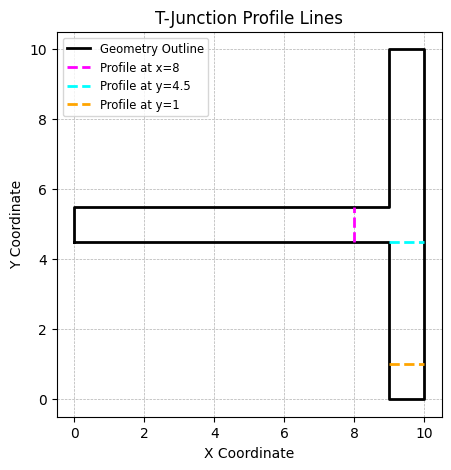

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_geometry_with_profiles(geom):
    """
    Visualize the geometry along with specific profile lines.

    Args:
        geom (Polygon): The geometry of the domain as a DeepXDE polygon.
    """
    plt.figure(figsize=(7, 5))

    # Extract polygon vertices to outline the geometry
    polygon_vertices = np.array(geom.vertices)
    polygon_vertices = np.vstack((polygon_vertices, polygon_vertices[0]))  # Close the polygon loop
    plt.plot(polygon_vertices[:, 0], polygon_vertices[:, 1], color='black', linewidth=2, label='Geometry Outline')

    # Add profile lines at predefined locations
    # Vertical profile at x = 8, from y = 4.5 to y = 5.5
    plt.plot([8, 8], [4.5, 5.5], color='magenta', linestyle='--', linewidth=2, label='Profile at x=8')

    # Horizontal profile at y = 4.5, from x = 9 to x = 10
    plt.plot([9, 10], [4.5, 4.5], color='cyan', linestyle='--', linewidth=2, label='Profile at y=4.5')

    # Horizontal profile at y = 1, from x = 9 to x = 10
    plt.plot([9, 10], [1, 1], color='orange', linestyle='--', linewidth=2, label='Profile at y=1')

    plt.title('T-Junction Profile Lines')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend(loc='upper left', fontsize='small', markerscale=1.5)
    plt.gca().set_aspect('equal', adjustable='box')  # Enforce equal aspect ratio for x and y
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# Example polygon class for the T-junction (replace with your geometry)
class Polygon:
    def __init__(self, vertices):
        self.vertices = vertices

# Replace with actual geometry vertices
vertices = np.array([[0, 4.5], [0, 5.5], [9, 5.5], [9, 10], [10, 10], [10, 0], [9, 0], [9, 4.5]])
geom = Polygon(vertices)

visualize_geometry_with_profiles(geom)


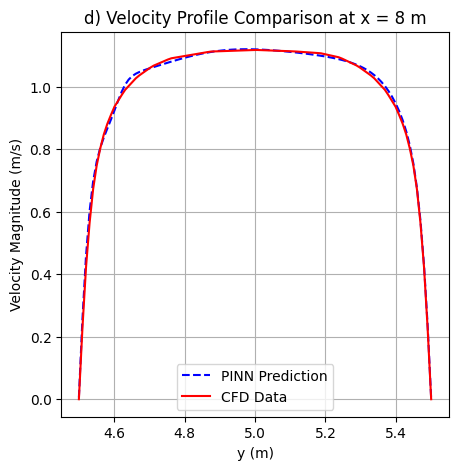

d) L2 normalized error for profile at x = 8 m: 0.99%


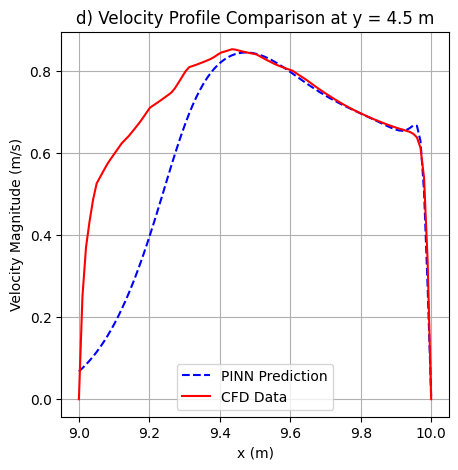

d) L2 normalized error for profile at y = 4.5 m: 24.98%


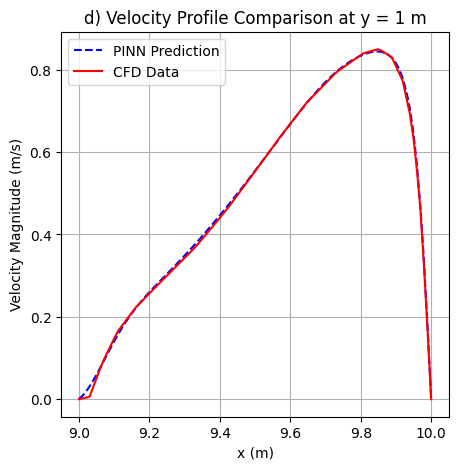

d) L2 normalized error for profile at y = 1 m: 1.05%


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def compare_velocity_profiles(model, cfd_data, fixed_axis=None, fixed_value=None, variable_start=None, variable_end=None, num_points=100, index_label=""):
    """
    Compare velocity profiles between PINN and CFD along a defined line.

    Args:
        model: The trained PINN model.
        cfd_data (dict): CFD interpolated data with keys for u, v.
        fixed_axis (str): 'x' or 'y', indicating the fixed coordinate axis.
        fixed_value (float): The fixed value for the specified axis.
        variable_start (float): Start value for the varying axis.
        variable_end (float): End value for the varying axis.
        num_points (int): Number of points along the profile line.
        index_label (str): Index for labeling the plot (e.g., "a)", "b)").

    Returns:
        None. Displays a plot comparing the velocity profiles.
    """
    # Define axes based on fixed coordinate
    line_axis = np.linspace(variable_start, variable_end, num_points)
    if fixed_axis == 'x':
        line_points = np.vstack((np.full(num_points, fixed_value), line_axis)).T
        position_label = "y (m)"
    elif fixed_axis == 'y':
        line_points = np.vstack((line_axis, np.full(num_points, fixed_value))).T
        position_label = "x (m)"
    else:
        raise ValueError("The argument 'fixed_axis' must be either 'x' or 'y'.")

    # Model predictions and CFD interpolation
    predictions = model.predict(line_points)
    u_pinn = predictions[:, 0]
    v_pinn = predictions[:, 1]
    velocity_magnitude_pinn = np.sqrt(u_pinn**2 + v_pinn**2)

    cfd_points = np.vstack((cfd_data['x'], cfd_data['y'])).T
    u_cfd = griddata(cfd_points, cfd_data['u'], line_points, method='linear')
    v_cfd = griddata(cfd_points, cfd_data['v'], line_points, method='linear')
    velocity_magnitude_cfd = np.sqrt(u_cfd**2 + v_cfd**2)

    # Normalized L2 error calculation
    l2_error = (np.linalg.norm(velocity_magnitude_pinn - velocity_magnitude_cfd) /
                np.linalg.norm(velocity_magnitude_cfd)) * 100  # As percentage

    # Plotting
    plt.figure(figsize=(5, 5))
    plt.plot(line_axis, velocity_magnitude_pinn, label='PINN Prediction', linestyle='--', color='blue')
    plt.plot(line_axis, velocity_magnitude_cfd, label='CFD Data', linestyle='-', color='red')
    plt.title(f"{index_label} Velocity Profile Comparison at {fixed_axis} = {fixed_value} m")
    plt.xlabel(position_label)
    plt.ylabel("Velocity Magnitude (m/s)")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"{index_label} L2 normalized error for profile at {fixed_axis} = {fixed_value} m: {l2_error:.2f}%")

# CFD data (example; replace with actual data)
cfd_data = {
    "x": all_x_coords.flatten(),
    "y": all_y_coords.flatten(),
    "u": u_true_denorm.flatten(),
    "v": v_true_denorm.flatten(),
}

# Function calls with different profile positions
compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='x',
    fixed_value=8,
    variable_start=4.5,
    variable_end=5.5,
    num_points=100,
    index_label="d)"
)

compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='y',
    fixed_value=4.5,
    variable_start=9,
    variable_end=10,
    num_points=100,
    index_label="d)"
)

compare_velocity_profiles(
    model=model,
    cfd_data=cfd_data,
    fixed_axis='y',
    fixed_value=1,
    variable_start=9,
    variable_end=10,
    num_points=100,
    index_label="d)"
)
